# Exploratory Analysis

This notebook contains all steps and decisions in the exploratory analysis phase of the pipeline.

---

## The Required Imports

Below are all the modules needed to run the code cells in this notebook.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_kepler_explore
from preprocessing import *
from univariate_analysis import *
from bivariate_analysis import *

---

## Acquire and Prepare the Data

Let's use the wrangle_kepler function to get the data.

In [2]:
kepler = wrangle_kepler_explore()
kepler.shape

(6031, 44)

---

## Split the Data

The plan is to build some machine learning models after exploration so let's split our data now to prevent data leakage.

In [3]:
# We'll split into three sets, the training set and two unseen data sets. This is a classification problem
# so we'll stratify on the disposition column.
train, validate, test = split_data(kepler, stratify = 'disposition')

In [4]:
train.shape, validate.shape, test.shape

((3376, 44), (1448, 44), (1207, 44))

---

## Explore

Now let's begin exploring the data. We'll only explore the train set and leave the other two alone.

### Univariate Analysis

#### Analyzing the Target

Let's see how the target is distributed.

In [5]:
train.disposition.value_counts()

FALSE POSITIVE    2107
CONFIRMED         1269
Name: disposition, dtype: int64

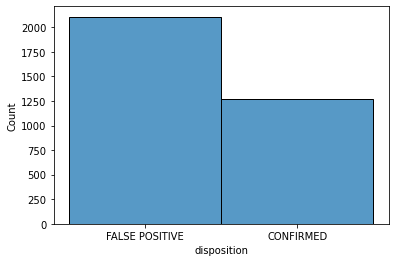

In [6]:
sns.histplot(data = train, x = 'disposition');

In [7]:
2107 / 3376

0.6241113744075829

In [8]:
1269 / 3376

0.37588862559241704

##### Takeaway

We mostly have false positives. The distribution is roughly 60/40 between false positives and confirmed exoplanets. With this in mind we should be fine using accuracy as a metric for measuring performance in modeling.

#### Analyzing Everything Else

Now let's see how all the other features are distributed.

In [9]:
%run univariate_analysis.py

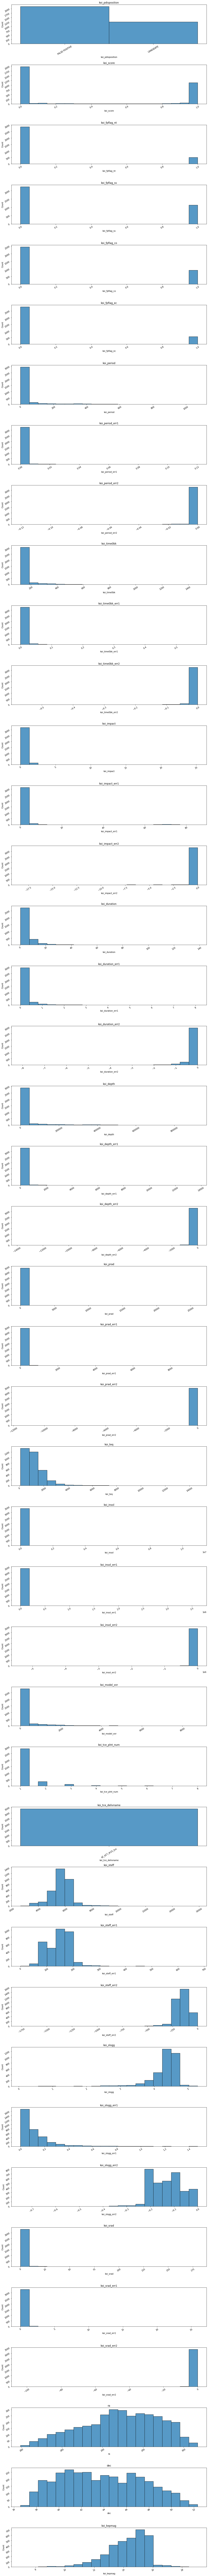

In [10]:
get_hist(train, train.drop(columns = 'disposition').columns)

##### Takeaway

There are a few features that possibly leak information about the target. These will be dropped, but we will verify the relationship first in the next section. A lot of features were the error of another feature. These likely won't be useful to us so they'll be dropped, perhaps at a later time these features can be analyzed. A few other features contain data that won't be very useful to us. These will also be dropped.

There were some features that had a lot of outliers that made seeing the distribution difficult. We'll take a look at those next.

#### Removing Outliers

Let's remove outliers from the following features and see the distributions again:
- koi_period
- koi_depth
- koi_prad
- koi_model_snr
- koi_srad

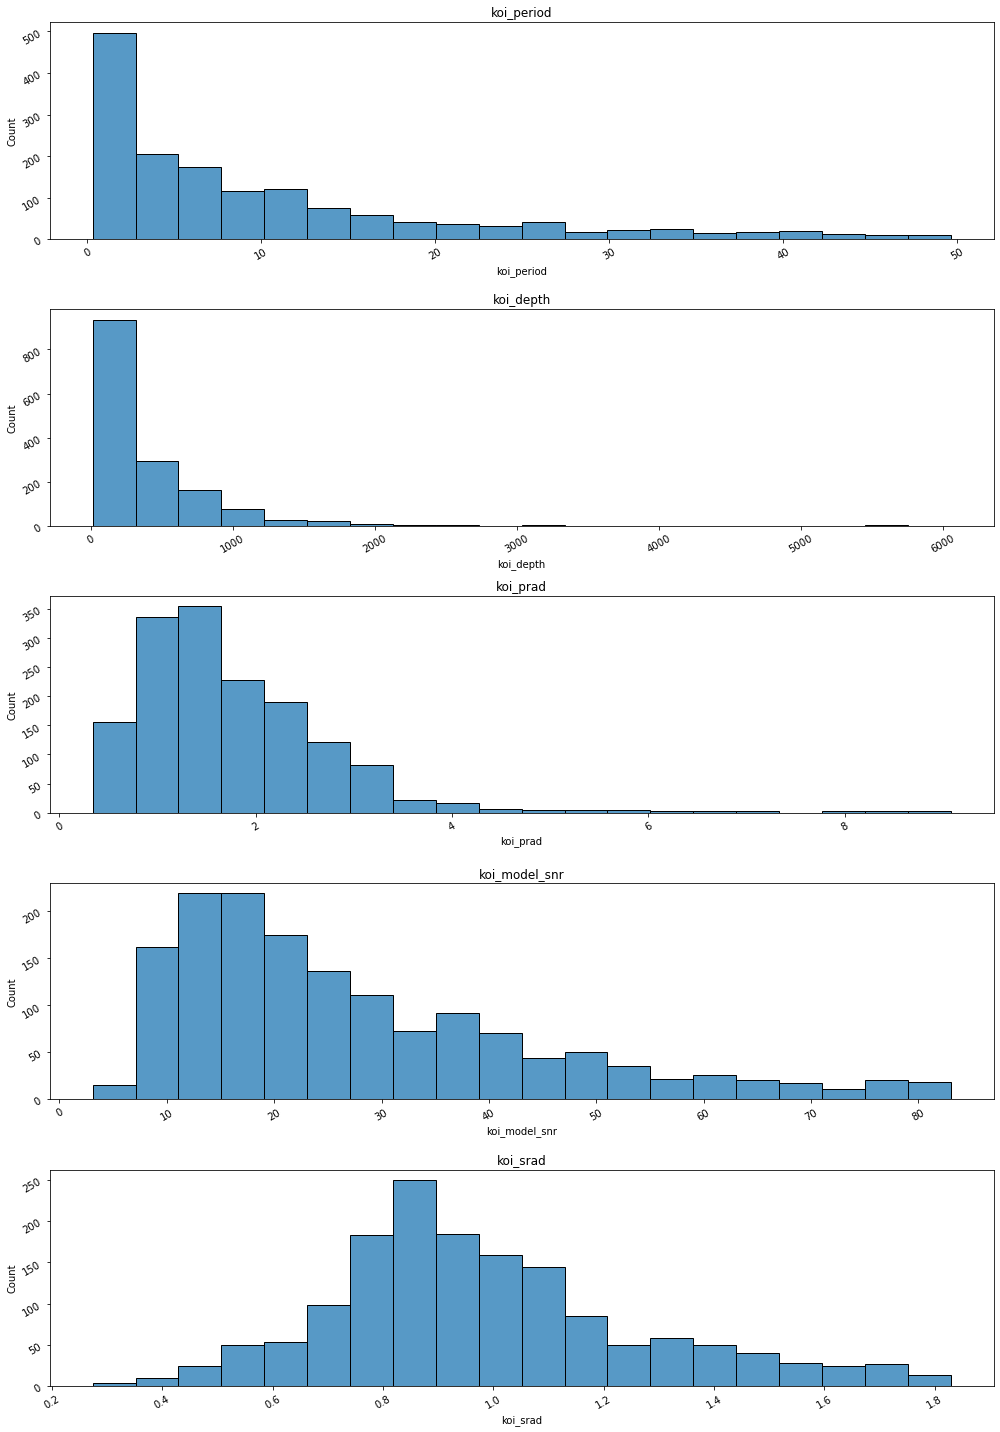

In [12]:
columns = [
    'koi_period',
    'koi_depth',
    'koi_prad',
    'koi_model_snr',
    'koi_srad'
]

get_hist(remove_outliers(train, 1.5, columns), columns)

In [13]:
remove_outliers(train, 1.5, columns).shape

(1537, 44)

##### Takeaway

Most of these features are right tailed. koi_srad has a roughly normal distribution. However, removing outliers does remove more than half of the observations. If one of these features proves to be useful for modeling we'll determine how to handle removing outliers in modeling.

#### Univariate Analysis Takeaways

Many features were discovered to not be very useful for the problem at hand. Some such as koi_pdisposition and koi_score possibly leak information about the target (though we'll confirm this shortly) and as such should not be used in modeling. Other features, such as those ending in err1 or err2, will not be used at this time due to time constraints. Although, I suspect these features might not be useful to us anyways, that is something to look into in a future pass through the pipeline. Some features like ra, dec, and koi_kepmag don't have much information in the data dictionary about what they are, but to the best of my knowledge are not directly related to the objects observed and as such will not be useful to us. There were also features like koi_tce_plnt_num, which is the planet number assigned to an exoplanet within its star system, and koi_tce_delivname, which only had 1 unique value, which will not be useful for other reasons. The following columns will be added to the drop list:

- koi_pdisposition
- koi_score
- koi_period_err1
- koi_period_err2
- koi_time0bk_err1
- koi_time0bk_err2
- koi_impact_err1
- koi_impact_err2
- koi_duration_err1
- koi_duration_err2
- koi_depth_err1
- koi_depth_err2
- koi_prad_err1
- koi_prad_err2
- koi_insol
- koi_insol_err1
- koi_insol_err2
- koi_tce_plnt_num
- koi_tce_delivname
- koi_steff_err1
- koi_steff_err2
- koi_slogg_err1
- koi_slogg_err2
- koi_srad_err1
- koi_srad_err2
- ra
- dec
- koi_kepmag

### Bivariate Analysis

Now let's see how each feature that we'll keep interacts with the target.

#### Verifying koi_pdisposition and koi_score Leak Information

Before we continue let's just verify that koi_pdisposition and koi_score leak information as I thought.

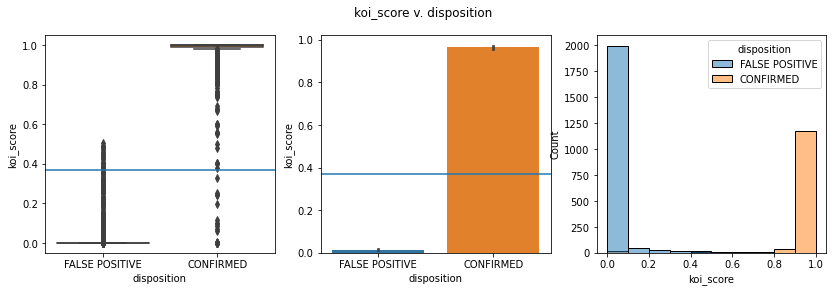

In [18]:
plot_categorical_and_continuous(train, ['disposition'], ['koi_score'])

There does seem to be a very strong relationship between disposition and koi_score. The koi_score is defined as the confidence in the disposition so it seems that this feature does in fact leak information.

In [20]:
train.disposition.value_counts(), train.koi_pdisposition.value_counts()

(FALSE POSITIVE    2107
 CONFIRMED         1269
 Name: disposition, dtype: int64,
 FALSE POSITIVE    2128
 CANDIDATE         1248
 Name: koi_pdisposition, dtype: int64)

The distribution of values here is very similar. So it seems that koi_pdisposition does leak information.

#### Set the Columns to Keep

In [14]:
columns_to_keep = [
    'koi_fpflag_nt',
    'koi_fpflag_ss',
    'koi_fpflag_co',
    'koi_fpflag_ec',
    'koi_period',
    'koi_time0bk',
    'koi_impact',
    'koi_duration',
    'koi_depth',
    'koi_prad',
    'koi_teq',
    'koi_model_snr',
    'koi_steff',
    'koi_slogg',
    'koi_srad'
]
len(columns_to_keep)

15

#### Plot Variables vs. Target

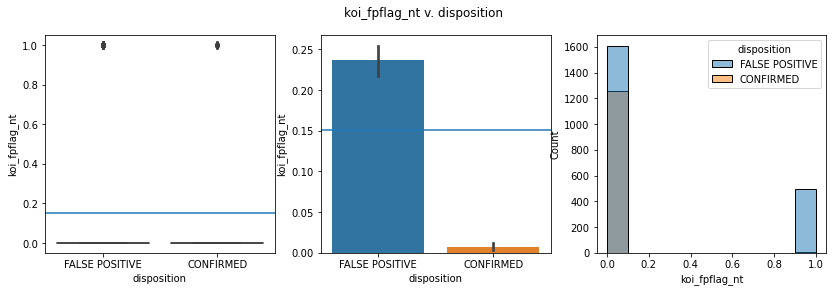

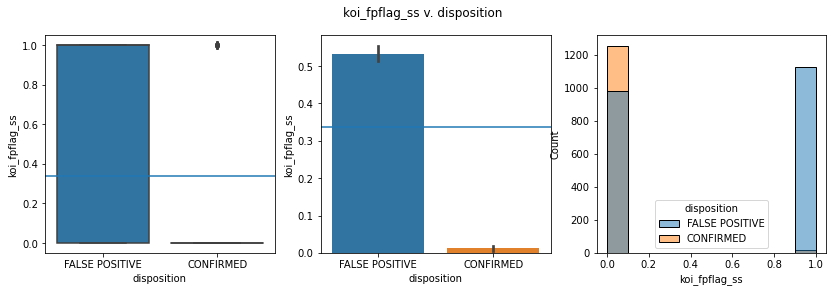

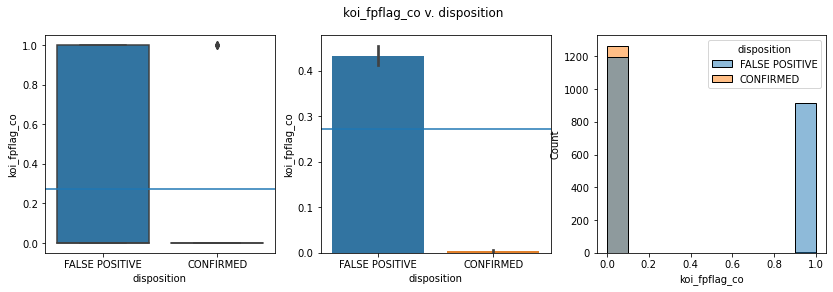

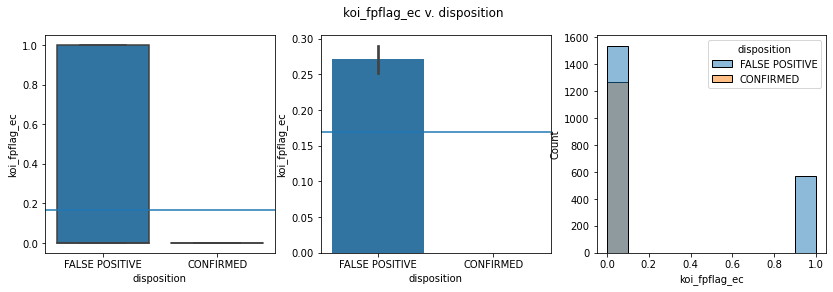

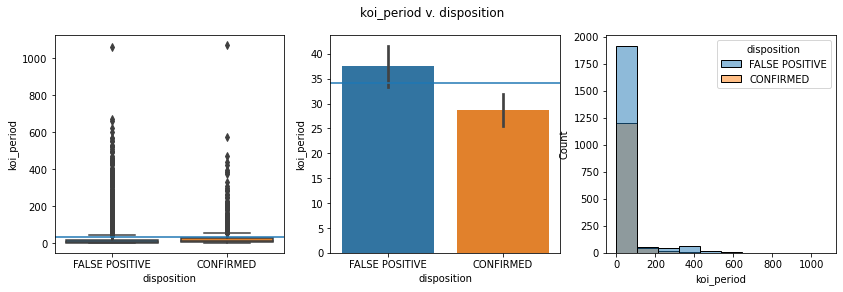

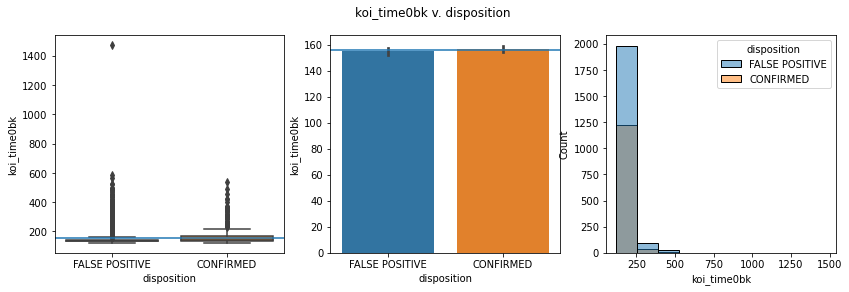

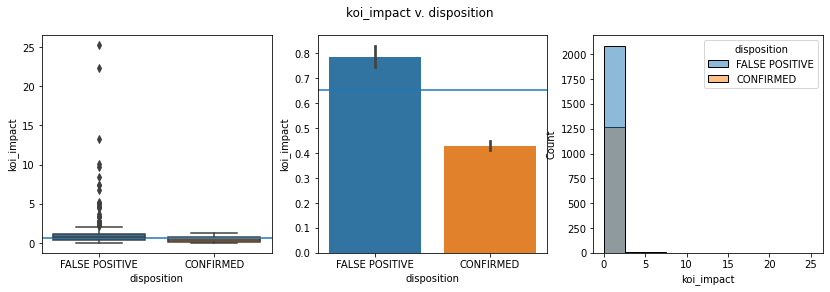

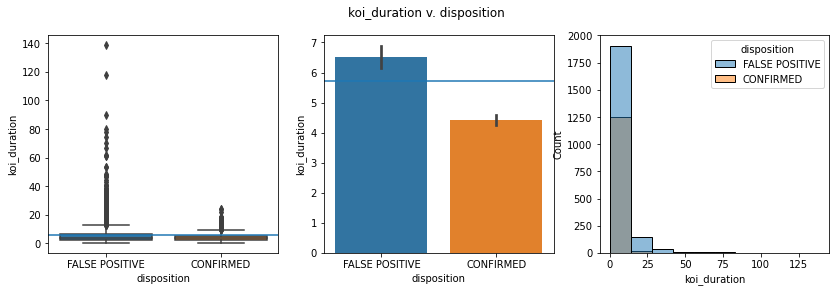

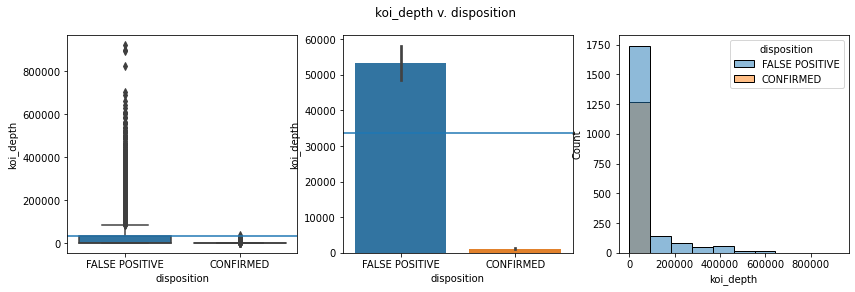

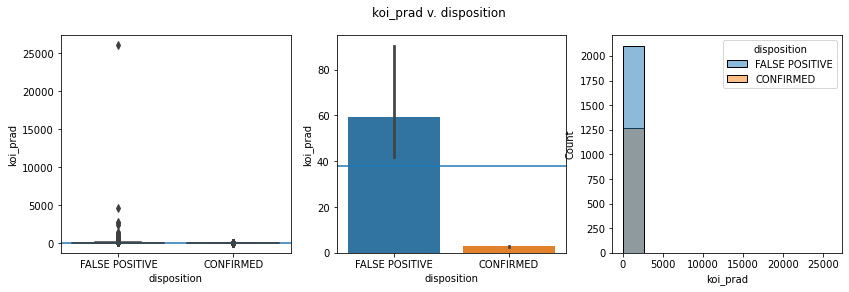

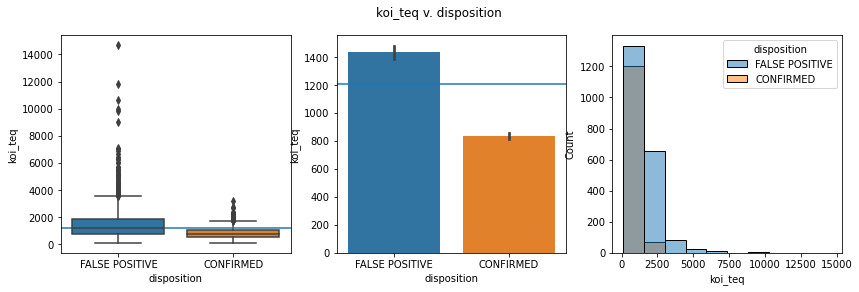

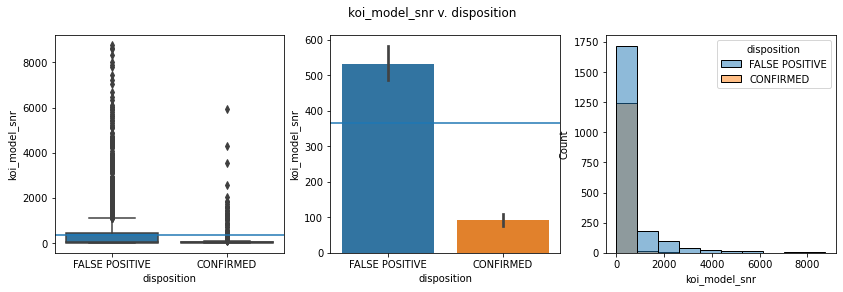

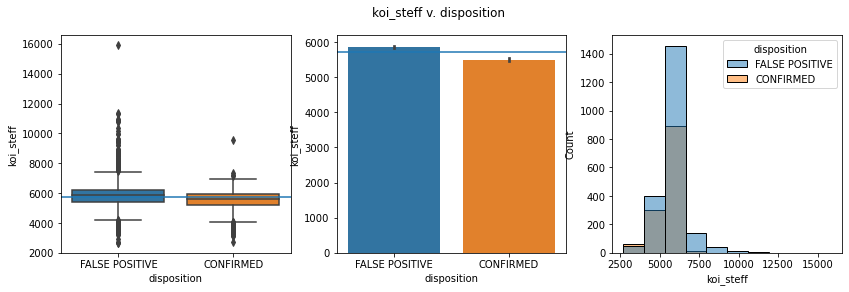

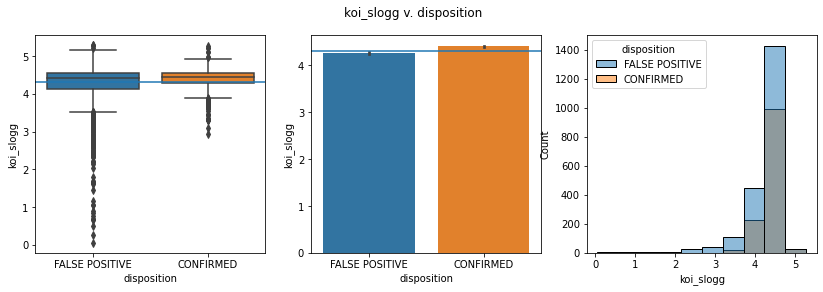

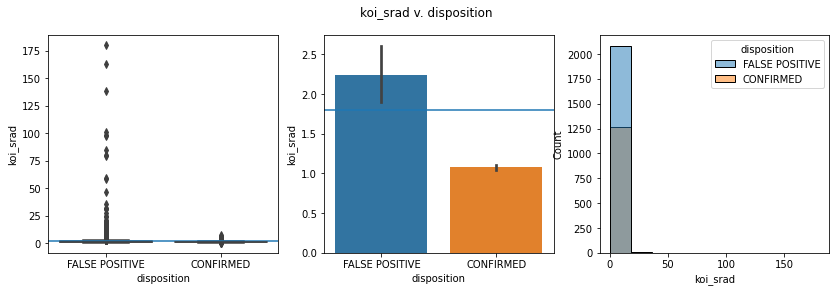

In [16]:
plot_categorical_and_continuous(train, ['disposition'], columns_to_keep)